**Using Copernicus Marine Toolbox**
- Dataset Info: cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D
- Time Range: 4th September 1997 - 22nd September 2025
- Processing Level: Level 3
- Sensor: Harmonized Multisensor

In [17]:
import copernicusmarine
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [18]:
chl_data = xr.open_mfdataset('C:\\Users\\ADMIN\\marine\\monsoon\\data\\*.nc', combine='by_coords')

In [19]:
chl_data['CHL']

<xarray.DataArray 'CHL' (time: 10246, latitude: 144, longitude: 240)> Size: 1GB
dask.array<concatenate, shape=(10246, 144, 240), dtype=float32, chunksize=(366, 144, 240), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 576B -5.979 -5.938 -5.896 ... -0.0625 -0.02084
  * longitude  (longitude) float32 960B 38.02 38.06 38.1 ... 47.9 47.94 47.98
  * time       (time) datetime64[ns] 82kB 1997-09-05 1997-09-06 ... 2025-09-23
Attributes:
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water
    valid_min:      0.0
    long_name:      Chlorophyll-a concentration - Mean of the binned pixels
    valid_max:      1000.0
    units:          milligram m-3

In [20]:
season_dict = {
    'north east monsoon': [1, 2, 12],
    'south east monsoon': [6, 7, 8],
    'long rains': [3, 4, 5],
    'short rains': [9, 10, 11]
}

In [21]:
def filter_by_szn(dataset:xr.Dataset, seasons_info:dict, season:str):
    filtered_ds = dataset.isel(time=dataset.time.dt.month.isin(seasons_info[season]))
    print(f"data filtered to {season} season")
    return filtered_ds

In [22]:
def composite_season(filtered_data:xr.Dataset, dimension:str):
    seasonal_composite = filtered_data.mean(dim=dimension)
    return seasonal_composite

In [23]:
def get_szn_timeseries(filtered_data:xr.Dataset, dimensions:list):
    daily_average = filtered_data.mean(dimensions)
    yearly_average = daily_average.groupby(daily_average.time.dt.year).mean()
    return yearly_average

In [40]:
composites = {}

for season in season_dict.keys():
    composite = chl_data.pipe(filter_by_szn, seasons_info=season_dict, season=season).pipe(composite_season, dimension='time')
    composites[season] = composite
composites

data filtered to north east monsoon season
data filtered to south east monsoon season
data filtered to long rains season
data filtered to short rains season


{'north east monsoon': <xarray.Dataset> Size: 140kB
 Dimensions:    (latitude: 144, longitude: 240)
 Coordinates:
   * latitude   (latitude) float32 576B -5.979 -5.938 -5.896 ... -0.0625 -0.02084
   * longitude  (longitude) float32 960B 38.02 38.06 38.1 ... 47.9 47.94 47.98
 Data variables:
     CHL        (latitude, longitude) float32 138kB dask.array<chunksize=(144, 240), meta=np.ndarray>,
 'south east monsoon': <xarray.Dataset> Size: 140kB
 Dimensions:    (latitude: 144, longitude: 240)
 Coordinates:
   * latitude   (latitude) float32 576B -5.979 -5.938 -5.896 ... -0.0625 -0.02084
   * longitude  (longitude) float32 960B 38.02 38.06 38.1 ... 47.9 47.94 47.98
 Data variables:
     CHL        (latitude, longitude) float32 138kB dask.array<chunksize=(144, 240), meta=np.ndarray>,
 'long rains': <xarray.Dataset> Size: 140kB
 Dimensions:    (latitude: 144, longitude: 240)
 Coordinates:
   * latitude   (latitude) float32 576B -5.979 -5.938 -5.896 ... -0.0625 -0.02084
   * longitude  (longi

In [42]:
time_series = {}
for season in season_dict.keys():
    yearly_averages = chl_data.pipe(filter_by_szn, seasons_info=season_dict, season=season).pipe(get_szn_timeseries, dimensions=['latitude', 'longitude'])
    time_series[season] = yearly_averages

time_series

data filtered to north east monsoon season
data filtered to south east monsoon season
data filtered to long rains season
data filtered to short rains season


{'north east monsoon': <xarray.Dataset> Size: 348B
 Dimensions:  (year: 29)
 Coordinates:
   * year     (year) int64 232B 1997 1998 1999 2000 2001 ... 2022 2023 2024 2025
 Data variables:
     CHL      (year) float32 116B dask.array<chunksize=(1,), meta=np.ndarray>,
 'south east monsoon': <xarray.Dataset> Size: 336B
 Dimensions:  (year: 28)
 Coordinates:
   * year     (year) int64 224B 1998 1999 2000 2001 2002 ... 2022 2023 2024 2025
 Data variables:
     CHL      (year) float32 112B dask.array<chunksize=(1,), meta=np.ndarray>,
 'long rains': <xarray.Dataset> Size: 336B
 Dimensions:  (year: 28)
 Coordinates:
   * year     (year) int64 224B 1998 1999 2000 2001 2002 ... 2022 2023 2024 2025
 Data variables:
     CHL      (year) float32 112B dask.array<chunksize=(1,), meta=np.ndarray>,
 'short rains': <xarray.Dataset> Size: 348B
 Dimensions:  (year: 29)
 Coordinates:
   * year     (year) int64 232B 1997 1998 1999 2000 2001 ... 2022 2023 2024 2025
 Data variables:
     CHL      (year) float

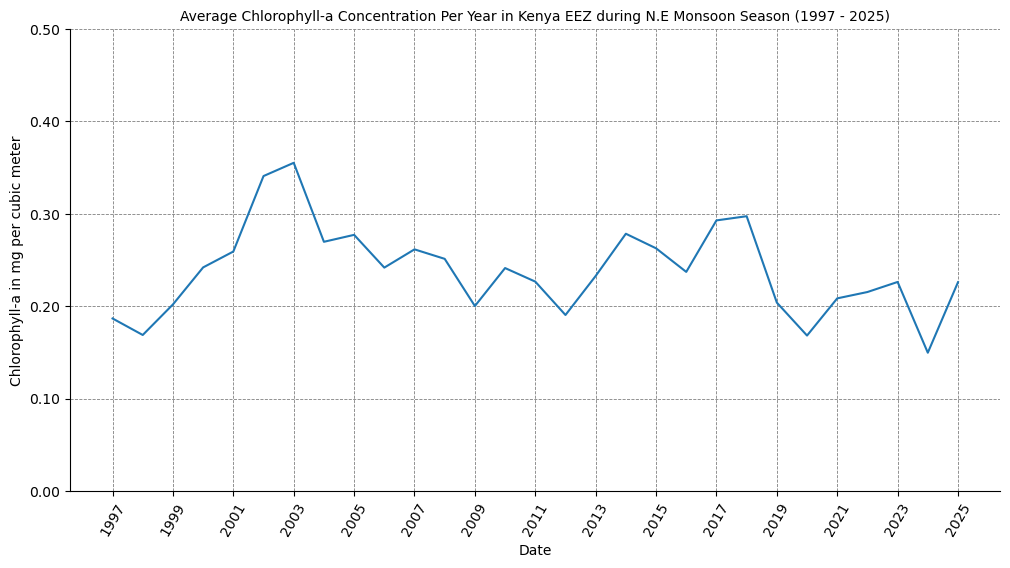

In [67]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(time_series['north east monsoon']['year'], time_series['north east monsoon']['CHL'])
ax.set_title('Average Chlorophyll-a Concentration Per Year in Kenya EEZ during N.E Monsoon Season (1997 - 2025)', fontdict={'size': 10, 'fontfamily':'sans serif', 'weight': 520}, ha='center')
ax.set_xlabel('Date')
ax.set_ylabel('Chlorophyll-a in mg per cubic meter')

xticks = np.arange(time_series['north east monsoon'].year.min(), (time_series['north east monsoon'].year.max() + 2), 2)
xtickla = [f'{xtick}' for xtick in xticks]
ax.xaxis.set_ticks(xticks)
ax.tick_params(axis='x', rotation=60)
ax.xaxis.set_ticklabels(xtickla)

yticks = np.arange(0, 0.6, 0.1)
ytickla = [f'{ytick:1.2f}' for ytick in yticks]
ax.yaxis.set_ticks(yticks)
ax.yaxis.set_ticklabels(ytickla)

ax.spines[['top', 'right']].set_visible(False)
ax.grid(visible=True, which='major', axis='both', color='grey', linestyle='--', linewidth=0.6)

In [54]:
np.arange(time_series['north east monsoon'].year.min(), (time_series['north east monsoon'].year.max() + 2), 2)

array([1997, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017,
       2019, 2021, 2023, 2025])